# Ground Sensors Variables Request Notebook

<center><img src=img/DDUST__Nero.png width="300"></center>

This notebook is used to download data from both meteorological and air quality ground sensors of the ARPA Lombardia network segment. In this introduction, these data are described to provide a clearer overview for the two datasets.

In detail, each sensor type, position, and time series are retrieved as follows:
- The ground sensor's type and position are always retrieved through the ARPA API. They are available at the following links: [Air quality stations](https://www.dati.lombardia.it/Ambiente/Stazioni-qualit-dell-aria/ib47-atvt) and [Meteorological stations](https://www.dati.lombardia.it/Ambiente/Stazioni-Meteorologiche/nf78-nj6b)
- Time series are available through API requests for the **current year only** (e.g. from January 2022 if the current year is 2022) for [Air quality data](https://www.dati.lombardia.it/Ambiente/Dati-sensori-aria/nicp-bhqi), while they are available for the **current month** for  [Meteorological data](https://www.dati.lombardia.it/Ambiente/Dati-sensori-meteo/647i-nhxk) (this may change in the future)
- To use data from previous years it's required to use the dataset in .csv format, such as [Air quality data for 2020]( https://www.dati.lombardia.it/Ambiente/Dati-sensori-aria-2020/88sp-5tmj) or [Meteorological data for 2020](https://www.dati.lombardia.it/Ambiente/Dati-sensori-meteo-2020/erjn-istm). It is possible to download the .zip folder containing these .csv data using the `DDUST_methods.py` contained inside the  `functions` folder. The links for downloading these data are contained inside the `AQ_sensor` and the `meteo_sensor` functions. One .zip folder for each year is available.

In this notebook, the zipped file is downloaded only if it's not already available in the working directory, otherwise the download is skipped.

In order to change the date range it is necessary to modify the time range in the `date.json` file and the right data will be automatically considered. This allows to have the same date selected across the D-DUST Jupyter notebooks.

<div class="alert alert-warning" role="alert">
<span>&#9888;</span>
<a id='warning'></a> Note: at the end of the notebook there is a function where ground sensor data interpolation is performed using Radial Basis Function (RBF) method (from Scipy (https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html) library) over the region of interest, in order to get continuous information of the air quality and meteorological data.
</div>

### Reference:
ARPA data from API are accessible using [Socrata Open Data API](https://dev.socrata.com/). <br>

Register on "Open Data Lombardia" to get the API token: https://www.dati.lombardia.it/login

The library [sodapy](https://github.com/xmunoz/sodapy) is a python client for the Socrata Open Data API.
The `app_token` is required to access the data. The token can be copied and pasted into the `keys.json` file (A sample of the `keys.json` file is provided in the repository)  or a `.env` file can be used in the working directory. It's just required to replace your token with those provided by ARPA.

## Import libraries

In [1]:
from sodapy import Socrata
import pandas as pd
import geopandas as gpd
import os
import zipfile
import requests
import json
import io
from scipy import stats
import numpy as np
import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets

# Set current working directory
cwd = os.getcwd()

# Import functions defined for DDUST project:
from functions import DDUST_methods

You can modify the `date.json` file to change the date range:

In [2]:
d = open('date.json')  # Import time range from the date.json file
date = json.load(d)
year = date['year']
custom_week = date['custom_week']

Select start and end dates:

In [3]:
# Select start and end date of the corresponding selected week:
start_date = datetime.datetime.strptime((str(year)+'-'+custom_week[0]), "%Y-%m-%d").date()
end_date = datetime.datetime.strptime((str(year)+'-'+custom_week[1]), "%Y-%m-%d").date()
print("The starting date is", start_date,"and the ending date is" , end_date,". The date is define as yyyy-mm-dd.")

The starting date is 2021-03-10 and the ending date is 2021-03-15 . The date is define as yyyy-mm-dd.


Prepare dates formatted properly and read the keys/tokens:

In [4]:
# Extract start, end dates and selected year for ARPA sensor. This is done to consider also the last day in the computation, otherwise it's skipped
start_date_dt = datetime.datetime.strptime((str(year)+'-'+custom_week[0]), '%Y-%m-%d')
end_date_dt = datetime.datetime.strptime((str(year)+'-'+custom_week[1]), '%Y-%m-%d')+timedelta(days=1) #increase 1 day to select data from arpa sensor correctly
start_date = str(start_date_dt)[0:10]
end_date = str(end_date_dt)[0:10]
year = datetime.datetime.strptime(start_date, '%Y-%m-%d').date().year

# Key and app token for Socrata API
f = open('keys.json')
keys = json.load(f)

#Z-Score threshold for removing outliers (at the end of each section)
threshold = 4  

----

# Import meteorological stations information and positions from ARPA API

This part will only request meteorological sensor information/metadata, types and positions from the API (there are no times series):

In [5]:
arpa_domain = "www.dati.lombardia.it"  # Select domain
m_st_descr = "nf78-nj6b" # Select dataset
client = Socrata(arpa_domain, app_token = keys['arpa_token'])  #Initialize client
results = client.get_all(m_st_descr)
meteo_st_descr = pd.DataFrame(results)
meteo_st_descr["idsensore"] = meteo_st_descr["idsensore"].astype(int)
meteo_st_descr

,idsensore,tipologia,unit_dimisura,idstazione,nomestazione,quota,provincia,datastart,storico,cgb_nord,cgb_est,lng,lat,location,:@computed_region_6hky_swhk,:@computed_region_ttgh_9sm5,datastop
0,10373,Precipitazione,mm,687,Ferno v.Di Dio,215,VA,2007-08-13T00:00:00.000,N,5051773,481053,8.756970445453431,45.61924377994763,"{'latitude': '45.61924377994763', 'longitude':...",1,1,NaN
1,10376,Precipitazione,mm,706,Lecco v.Sora,272,LC,2008-07-22T00:00:00.000,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaN
2,10377,Temperatura,°C,706,Lecco v.Sora,272,LC,2008-07-22T00:00:00.000,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaN
3,10381,Umidità Relativa,%,706,Lecco v.Sora,272,LC,2008-07-22T00:00:00.000,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaN
4,10382,Radiazione Globale,W/m²,706,Lecco v.Sora,272,LC,2008-07-31T00:00:00.000,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,9869,Umidità Relativa,%,672,Cornale v.Libertà,74,PV,2005-07-28T00:00:00.000,N,4987406,493238,8.914144599002409,45.04007657202963,"{'latitude': '45.04007657202963', 'longitude':...",7,7,NaN
1228,9933,Precipitazione,mm,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10T00:00:00.000,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",8,8,NaN
1229,9935,Radiazione Globale,W/m²,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10T00:00:00.000,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",8,8,NaN
1230,9938,Temperatura,°C,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10T00:00:00.000,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",8,8,NaN


---

# Import Meteorological data from ARPA API (current month data) or .csv file (past years)

The next code is used to request data from API (**only current month for meteorological data**) or download the .zip folder containing the .csv files (past years data).

In [6]:
# If current month is selected, use data from API (only current months data ara available from meteo sensors)
if int(year) == datetime.datetime.today().year:
    
    # Set domain and token 
    arpa_domain = "www.dati.lombardia.it"
    dati = "647i-nhxk" #change this depending on the dataset (check Open Data Lombardia datasets)
    
    # Query the data
    client = Socrata(arpa_domain, app_token = keys['arpa_token']) #insert your arpa_token
    date_query = "data > {} and data < {}".format('"'+ start_date + '"','"'+ end_date + '"')
    results = client.get(dati, where=date_query, limit=5000000000000)
    
    # Create the dataframe
    meteo_data = pd.DataFrame(results)
    meteo_data.rename(columns={'IdSensore': 'idsensore','Data': 'data','idOperatore': 'idoperatore','Stato': 'stato','Valore': 'valore'}, inplace=True)
    meteo_data['data'] =  pd.to_datetime(meteo_data['data'], format='%Y/%m/%d %H:%M:%S')
    meteo_data_df = meteo_data.astype({"idsensore": int,"valore": float})
    
# If data from previous years are requested then download the corresponding .zip file, extract the .csv file and filter the dates  
elif int(year) < datetime.datetime.today().year:
    filename_meteo = 'meteo_'+str(year)+'.zip'
    
    #if file does not exist then download it
    if not os.path.exists(os.path.join(filename_meteo)):
        csv_url = my_methods.meteo_sensor(str(year))
        r_meteo = requests.get(csv_url, allow_redirects=True)
        DL_zip = open(filename, 'wb').write(r_meteo.content)
        print('Dowloaded zip file')
    
    print('Zip file exist')
    
    # Open the zip file
    archive = zipfile.ZipFile(filename_meteo, 'r')
    data = archive.open(str(year)+'.csv') 
    
    # Create dataframe
    # Keep meteo_data_df in memory so is possible to use it for other time periods
    meteo_data_df = pd.read_csv(data, dtype={"IdSensore": int,"Valore": float, "Stato": str, "idOperatore":str})
    meteo_data_df.rename(columns={'IdSensore': 'idsensore','Data': 'data','idOperatore': 'idoperatore','Stato': 'stato','Valore': 'valore'}, inplace=True)
    meteo_data_df['data'] =  pd.to_datetime(meteo_data_df['data'], format='%d/%m/%Y %H:%M:%S')

Zip file exist


In [7]:
#Mask meteo_data_df
mask = (meteo_data_df.data >= start_date) & (meteo_data_df.data < end_date)
meteo_data = meteo_data_df.loc[mask]

- - -

# Meteorological data processing 

Drop `stato`, `idoperatore` columns and select valid data different from -9999:

In [8]:
meteo_data = meteo_data.drop(columns=['stato', 'idoperatore'])
meteo_data = meteo_data[meteo_data.valore.astype(float) != -9999]

In [9]:
#Check the dataframe
meteo_data

,idsensore,data,valore
10400251,3,2021-03-10 00:00:00,40.0
10400252,6,2021-03-10 00:00:00,52.8
10400253,9,2021-03-10 00:00:00,0.0
10400254,11,2021-03-10 00:00:00,0.0
10400255,13,2021-03-10 00:00:00,0.4
...,...,...,...
11404732,32413,2021-03-15 23:50:00,0.0
11404733,5078,2021-03-15 23:50:00,49.4
11404734,5080,2021-03-15 23:50:00,60.5
11404735,5082,2021-03-15 23:50:00,49.1


Get sensors unique types:

In [10]:
meteo_st_descr.tipologia.unique()

array(['Precipitazione', 'Temperatura', 'Umidità Relativa',
       'Radiazione Globale', 'Direzione Vento', 'Velocità Vento',
       'Livello Idrometrico', 'Altezza Neve'], dtype=object)

Select relevant sensors by adding them to the following list:

In [11]:
m_sensor_sel = ['Precipitazione','Temperatura','Umidità Relativa','Direzione Vento','Velocità Vento', 'Radiazione Globale']

Join sensors data with their descriptions and information:

In [12]:
meteo_table = pd.merge(meteo_data, meteo_st_descr, on = 'idsensore')

Filter sensor by type using the `m_sensor_list`, checking if their type is in that list:

In [13]:
meteo_table['tipologia'].astype(str)
meteo_table = meteo_table[meteo_table['tipologia'].isin(m_sensor_sel)]

In [14]:
temp_st = meteo_table.loc[meteo_table['tipologia'] == 'Temperatura']
prec_st = meteo_table.loc[meteo_table['tipologia'] == 'Precipitazione']
air_hum_st = meteo_table.loc[meteo_table['tipologia'] == 'Umidità Relativa']
wind_dir_st = meteo_table.loc[meteo_table['tipologia'] == 'Direzione Vento']
wind_speed_st = meteo_table.loc[meteo_table['tipologia'] == 'Velocità Vento']
rad_glob_st = meteo_table.loc[meteo_table['tipologia'] == 'Radiazione Globale']

Since Wind Direction's values are expressed in Degrees North, the are divided into 8 categories:
 - `1` -> North: 0° - 22.5° / 337.5° - 360°
 - `2` -> North-East: 22.5° - 67.5°         
 - `3` -> East: 67.5° - 112.5°              
 - `4` -> South-East: 112.5° - 157.5°       
 - `5` -> South: 15.5° - 202.5°             
 - `6` -> South-West: 202.5° - 247.5°       
 - `7` -> West: 247.5° - 292.5°             
 - `8` -> North-West: 292.5° - 337.5°       

In [15]:
wind_dir_st = wind_dir_st.rename(columns={"valore": "direzione"})
wind_dir_st.loc[(wind_dir_st.direzione >= 0 ) & (wind_dir_st.direzione < 22.5 ), 'valore'] = 1
wind_dir_st.loc[(wind_dir_st.direzione > 337.5 ) & (wind_dir_st.direzione <= 360 ), 'valore'] = 1
wind_dir_st.loc[(wind_dir_st.direzione >= 22.5 ) & (wind_dir_st.direzione < 67.5 ), 'valore'] = 2
wind_dir_st.loc[(wind_dir_st.direzione >= 67.5 ) & (wind_dir_st.direzione < 112.5 ), 'valore'] = 3
wind_dir_st.loc[(wind_dir_st.direzione >= 112.5 ) & (wind_dir_st.direzione < 157.5 ), 'valore'] = 4
wind_dir_st.loc[(wind_dir_st.direzione >= 157.5 ) & (wind_dir_st.direzione < 202.5 ), 'valore'] = 5
wind_dir_st.loc[(wind_dir_st.direzione >= 202.5 ) & (wind_dir_st.direzione < 247.5 ), 'valore'] = 6
wind_dir_st.loc[(wind_dir_st.direzione >= 247.5 ) & (wind_dir_st.direzione < 292.5 ), 'valore'] = 7
wind_dir_st.loc[(wind_dir_st.direzione >= 292.5 ) & (wind_dir_st.direzione <= 337.5 ), 'valore'] = 8
wind_dir_st = wind_dir_st.groupby('idsensore')['valore'].apply(lambda x: x.mode().iat[0]).reset_index()
wind_dir_st = pd.merge(wind_dir_st, meteo_st_descr, on = 'idsensore')

To remove outliers from `precipitation` we consider a threshold of 100 mm/h (the values coming from the station are stored every 10 minutes).

In [16]:
# precipitation values less than 100 to remove outliers
prec_st = prec_st[prec_st.valore < 100]
prec_st = prec_st.groupby(['idsensore'],as_index=False).mean()
prec_st = pd.merge(prec_st, meteo_st_descr, on = 'idsensore')

To remove outliers from other variables we can calculate the corresponding Z-Scores  and calculate mean:

In [17]:
temp_st['zscore'] = np.abs(stats.zscore(temp_st['valore'], nan_policy='propagate'))
temp_st = temp_st[temp_st.zscore < threshold]
temp_st = temp_st.groupby(['idsensore'],as_index=False).mean()
temp_st = pd.merge(temp_st, meteo_st_descr, on = 'idsensore')

In [18]:
air_hum_st['zscore'] = np.abs(stats.zscore(air_hum_st['valore'], nan_policy='propagate'))
air_hum_st = air_hum_st[air_hum_st.zscore < threshold]
air_hum_st = air_hum_st.groupby(['idsensore'],as_index=False).mean()
air_hum_st = pd.merge(air_hum_st, meteo_st_descr, on = 'idsensore')

In [19]:
rad_glob_st['zscore'] = np.abs(stats.zscore(rad_glob_st['valore'], nan_policy='propagate'))
rad_glob_st = rad_glob_st[rad_glob_st.zscore < threshold]
rad_glob_st = rad_glob_st.groupby(['idsensore'],as_index=False).mean()
rad_glob_st = pd.merge(rad_glob_st, meteo_st_descr, on = 'idsensore')

In [20]:
wind_speed_st['zscore'] = np.abs(stats.zscore(wind_speed_st['valore'], nan_policy='propagate'))
wind_speed_st = wind_speed_st[wind_speed_st.zscore < threshold]
wind_speed_st = wind_speed_st.groupby(['idsensore'],as_index=False).mean()
wind_speed_st = pd.merge(wind_speed_st, meteo_st_descr, on = 'idsensore')

Save sensors separately and create a `.gpkg` file for each one:

In [21]:
temp_gdf = gpd.GeoDataFrame(temp_st, geometry=gpd.points_from_xy(temp_st.lng, temp_st.lat))
temp_gdf = temp_gdf.set_crs('epsg:4326')
prec_gdf = gpd.GeoDataFrame(prec_st, geometry=gpd.points_from_xy(prec_st.lng, prec_st.lat))
prec_gdf = prec_gdf.set_crs('epsg:4326')
air_hum_gdf = gpd.GeoDataFrame(air_hum_st, geometry=gpd.points_from_xy(air_hum_st.lng, air_hum_st.lat))
air_hum_gdf = air_hum_gdf.set_crs('epsg:4326')
wind_dir_gdf = gpd.GeoDataFrame(wind_dir_st, geometry=gpd.points_from_xy(wind_dir_st.lng, wind_dir_st.lat))
wind_dir_gdf = wind_dir_gdf.set_crs('epsg:4326')
wind_speed_gdf = gpd.GeoDataFrame(wind_speed_st, geometry=gpd.points_from_xy(wind_speed_st.lng, wind_speed_st.lat))
wind_speed_gdf = wind_speed_gdf.set_crs('epsg:4326')
rad_glob_gdf = gpd.GeoDataFrame(rad_glob_st, geometry=gpd.points_from_xy(rad_glob_st.lng, rad_glob_st.lat))
rad_glob_gdf = rad_glob_gdf.set_crs('epsg:4326')

Save in the temporary `temp` folder:

In [22]:
temp_gdf.to_file(cwd+"/temp/temp_st.gpkg", driver="GPKG")
prec_gdf.to_file(cwd+"/temp/prec_st.gpkg", driver="GPKG")
air_hum_gdf.to_file(cwd+"/temp/air_hum_st.gpkg", driver="GPKG")
wind_dir_gdf.to_file(cwd+"/temp/wind_dir_st.gpkg", driver="GPKG")
wind_speed_gdf.to_file(cwd+"/temp/wind_speed_st.gpkg", driver="GPKG")
rad_glob_gdf.to_file(cwd+"/temp/rad_glob_st.gpkg", driver="GPKG")

---

# Import Air Quality stations information and positions from ARPA API

This sections has the same structure of the previous one. First, import air quality sensors descriptions/metadata, typs and positions from the API:

In [23]:
arpa_domain = "www.dati.lombardia.it"
st_descr = "ib47-atvt"

client = Socrata(arpa_domain, app_token = keys['arpa_token']) 
results = client.get_all(st_descr)

air_st_descr = pd.DataFrame(results)
air_st_descr["idsensore"] = air_st_descr["idsensore"].astype(int)

- - - 

# Import Air Quality data from ARPA API (current year data) or .csv file (past years)

For Air Quality data, they are available through the API for the current year. For older data the .csv file must be used:

In [24]:
# If current year is selected use data from API
if int(year) == datetime.datetime.today().year:
    
    # Set domain and token 
    arpa_domain = "www.dati.lombardia.it"
    dati = "nicp-bhqi" #change this depending on the dataset (check Open Data Lombardia datasets)
    client = Socrata(arpa_domain, app_token = keys['arpa_token'])
    
    # Query the data
    date_query = "data > {} and data < {}".format('"'+ start_date + '"','"'+ end_date + '"')  #select date 
    results = client.get(dati, where=date_query, limit=5000000000)  # query
    
    # Create the dataframe
    aq_data = pd.DataFrame(results) #create Dataframe
    aq_data.rename(columns={'IdSensore': 'idsensore','Data': 'data','idOperatore': 'idoperatore','Stato': 'stato','Valore': 'valore'}, inplace=True)
    aq_data['data'] =  pd.to_datetime(aq_data['data'], format='%Y/%m/%d %H:%M:%S')
    aq_data_df = aq_data.astype({"idsensore": int,"valore": float})
    
# If data from previous years are requested then download the corresponding .zip file, extract the .csv file and filter the dates  
elif int(year) < datetime.datetime.today().year:
    filename_aq = 'aq_'+str(year)+'.zip'
    
    #if file does not exist then download it
    if not os.path.exists(os.path.join(filename_aq)):
        csv_url = my_methods.AQ_sensor(str(year))
        r_aq = requests.get(csv_url, allow_redirects=True)
        DL_zip = open(filename_aq, 'wb').write(r_aq.content)
        print('Dowloaded zip file')
    
    print('Zip file exist')
    
    # Open the zip file
    archive = zipfile.ZipFile('aq_'+str(year)+'.zip', 'r')
    data = archive.open(str(year)+'.csv') #open the zip
    
    # Create dataframe
    aq_data_df=pd.read_csv(data)
    aq_data_df.rename(columns={'IdSensore': 'idsensore','Data': 'data','idOperatore': 'idoperatore','Stato': 'stato','Valore': 'valore'}, inplace=True)
    aq_data_df['data'] =  pd.to_datetime(aq_data_df['data'], format='%d/%m/%Y %H:%M:%S')

Zip file exist


In [25]:
mask = (aq_data_df.data >= start_date) & (aq_data_df.data < end_date)
aq_data = aq_data_df.loc[mask]

- - -

# Air quality data processing

Drop "stato" and "idoperatore" columns and select valid values different from -9999:

In [26]:
aq_data = aq_data.drop(columns=['stato', 'idoperatore'])
aq_data = aq_data[aq_data.valore.astype(float) != -9999]

Get the unique sensor type names:

In [27]:
air_st_descr.nometiposensore.unique()

array(['Ossidi di Azoto', 'Monossido di Carbonio', 'Biossido di Azoto',
       'Biossido di Zolfo', 'Particelle sospese PM2.5', 'Benzene',
       'Ozono', 'PM10 (SM2005)', 'Particolato Totale Sospeso',
       'Ammoniaca', 'Nikel', 'Arsenico', 'Cadmio', 'Piombo',
       'Benzo(a)pirene', 'BlackCarbon', 'Monossido di Azoto', 'PM10'],
      dtype=object)

Select relevant sensors and put them in the following list:

In [28]:
sensor_sel = ['Ossidi di Azoto', 'Monossido di Carbonio', 'Biossido di Azoto','Ozono',
       'Biossido di Zolfo', 'Particelle sospese PM2.5','Ammoniaca','PM10 (SM2005)']

Join sensors description and information with the mean value:

In [29]:
aq_table = pd.merge(aq_data, air_st_descr, on='idsensore')

Select sensors adding their names to the list:

In [30]:
aq_table['nometiposensore'].astype(str)
aq_table = aq_table[aq_table['nometiposensore'].isin(sensor_sel)]

In [31]:
pm25_st = aq_table.loc[aq_table['nometiposensore'] == 'Particelle sospese PM2.5']
co_st = aq_table.loc[aq_table['nometiposensore'] == 'Monossido di Carbonio']
no2_st = aq_table.loc[aq_table['nometiposensore'] == 'Biossido di Azoto']
so2_st = aq_table.loc[aq_table['nometiposensore'] == 'Biossido di Zolfo']
nh3_st = aq_table.loc[aq_table['nometiposensore'] == 'Ammoniaca']
nox_st = aq_table.loc[aq_table['nometiposensore'] == 'Ossidi di Azoto']
pm10_st = aq_table.loc[aq_table['nometiposensore'] == 'PM10 (SM2005)']
o3_st = aq_table.loc[aq_table['nometiposensore'] == 'Ozono']

Z-Test to remove outliers and calculate mean:

In [32]:
pm25_st['zscore'] = np.abs(stats.zscore(pm25_st['valore'], nan_policy='propagate'))
pm25_st = pm25_st[pm25_st.zscore < threshold]
pm25_st = pm25_st.groupby(['idsensore'],as_index=False).mean()
pm25_st = pd.merge(pm25_st, air_st_descr, on='idsensore')

In [33]:
co_st['zscore'] = np.abs(stats.zscore(co_st['valore'], nan_policy='propagate'))
co_st = co_st[co_st.zscore < threshold]
co_st = co_st.groupby(['idsensore'],as_index=False).mean()
co_st = pd.merge(co_st, air_st_descr, on='idsensore')

In [34]:
no2_st['zscore'] = np.abs(stats.zscore(no2_st['valore'], nan_policy='propagate'))
no2_st = no2_st[no2_st.zscore < threshold]
no2_st = no2_st.groupby(['idsensore'],as_index=False).mean()
no2_st = pd.merge(no2_st, air_st_descr, on='idsensore')

In [35]:
so2_st['zscore'] = np.abs(stats.zscore(so2_st['valore'], nan_policy='propagate'))
so2_st = so2_st[so2_st.zscore < threshold]
so2_st = so2_st.groupby(['idsensore'],as_index=False).mean()
so2_st = pd.merge(so2_st, air_st_descr, on='idsensore')

In [36]:
nh3_st['zscore'] = np.abs(stats.zscore(nh3_st['valore'], nan_policy='propagate'))
nh3_st = nh3_st[nh3_st.zscore < threshold]
nh3_st = nh3_st.groupby(['idsensore'],as_index=False).mean()
nh3_st = pd.merge(nh3_st, air_st_descr, on='idsensore')

In [37]:
nox_st['zscore'] = np.abs(stats.zscore(nox_st['valore'], nan_policy='propagate'))
nox_st = nox_st[nox_st.zscore < threshold]
nox_st = nox_st.groupby(['idsensore'],as_index=False).mean()
nox_st = pd.merge(nox_st, air_st_descr, on='idsensore')

In [38]:
pm10_st['zscore'] = np.abs(stats.zscore(pm10_st['valore'], nan_policy='propagate'))
pm10_st = pm10_st[pm10_st.zscore < threshold]
pm10_st = pm10_st.groupby(['idsensore'],as_index=False).mean()
pm10_st = pd.merge(pm10_st, air_st_descr, on='idsensore')

In [39]:
o3_st['zscore'] = np.abs(stats.zscore(o3_st['valore'], nan_policy='propagate'))
o3_st = o3_st[o3_st.zscore < threshold]
o3_st = o3_st.groupby(['idsensore'],as_index=False).mean()
o3_st = pd.merge(o3_st, air_st_descr, on='idsensore')

Save sensors separately and create a .gpkg file for each one. They contain the mean value for that given variable calculated over the defined time range:

In [40]:
pm25_gdf = gpd.GeoDataFrame(pm25_st, geometry=gpd.points_from_xy(pm25_st.lng, pm25_st.lat))
pm25_gdf = pm25_gdf.set_crs('epsg:4326')
co_gdf = gpd.GeoDataFrame(co_st, geometry=gpd.points_from_xy(co_st.lng, co_st.lat))
co_gdf = co_gdf.set_crs('epsg:4326')
no2_gdf = gpd.GeoDataFrame(no2_st, geometry=gpd.points_from_xy(no2_st.lng, no2_st.lat))
no2_gdf = no2_gdf.set_crs('epsg:4326')
so2_gdf = gpd.GeoDataFrame(so2_st, geometry=gpd.points_from_xy(so2_st.lng, so2_st.lat))
so2_gdf = so2_gdf.set_crs('epsg:4326')
nh3_gdf = gpd.GeoDataFrame(nh3_st, geometry=gpd.points_from_xy(nh3_st.lng, nh3_st.lat))
nh3_gdf = nh3_gdf.set_crs('epsg:4326')
nox_gdf = gpd.GeoDataFrame(nox_st, geometry=gpd.points_from_xy(nox_st.lng, nox_st.lat))
nox_gdf = nox_gdf.set_crs('epsg:4326')
pm10_gdf = gpd.GeoDataFrame(pm10_st, geometry=gpd.points_from_xy(pm10_st.lng, pm10_st.lat))
pm10_gdf = pm10_gdf.set_crs('epsg:4326')
o3_gdf = gpd.GeoDataFrame(o3_st, geometry=gpd.points_from_xy(o3_st.lng, o3_st.lat))
o3_gdf = o3_gdf.set_crs('epsg:4326')

Save in a **temp** folder:

In [41]:
pm25_gdf.to_file(cwd+"/temp/pm25_st.gpkg", driver="GPKG")
co_gdf.to_file(cwd+"/temp/co_st.gpkg", driver="GPKG")
no2_gdf.to_file(cwd+"/temp/no2_st.gpkg", driver="GPKG")
so2_gdf.to_file(cwd+"/temp/so2_st.gpkg", driver="GPKG")
nh3_gdf.to_file(cwd+"/temp/nh3_st.gpkg", driver="GPKG")
nox_gdf.to_file(cwd+"/temp/nox_st.gpkg", driver="GPKG")
pm10_gdf.to_file(cwd+"/temp/pm10_st.gpkg", driver="GPKG")
o3_gdf.to_file(cwd+"/temp/o3_st.gpkg", driver="GPKG")

---

# Sensor interpolation using Radial Basis Functions (RBF)

ARPA sensors are interpolated using Scipy Radial Basis Functions (RBF) (this is not dont for ESA Air Quality Platforms they are few).

In [42]:
from osgeo import gdal
from osgeo import ogr
import rasterio as rio
from rasterio.transform import Affine
from rasterio.crs import CRS
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [43]:
pm25_gdf = pm25_gdf.to_crs('epsg:32632')
co_gdf = co_gdf.to_crs('epsg:32632')
no2_gdf = no2_gdf.to_crs('epsg:32632')
so2_gdf = so2_gdf.to_crs('epsg:32632')
nh3_gdf = nh3_gdf.to_crs('epsg:32632')
nox_gdf = nox_gdf.to_crs('epsg:32632')
pm10_gdf = pm10_gdf.to_crs('epsg:32632')
o3_gdf = o3_gdf.to_crs('epsg:32632')

In [44]:
temp_gdf = temp_gdf.to_crs('epsg:32632')
prec_gdf = prec_gdf.to_crs('epsg:32632')
air_hum_gdf = air_hum_gdf.to_crs('epsg:32632')
wind_dir_gdf = wind_dir_gdf.to_crs('epsg:32632')
wind_speed_gdf = wind_speed_gdf.to_crs('epsg:32632')
rad_glob_gdf = rad_glob_gdf.to_crs('epsg:32632')

In [45]:
bb = gdal.Open(cwd+"/bounding_box/bounding_box_buffer20_raster_32632.tif")  #use a predefined raster to set dimensions
gt = bb.GetGeoTransform()
ulx = gt[0]
uly = gt[3]
resx = gt[1]
resy = gt[5]
xsize = bb.RasterXSize
ysize = bb.RasterYSize
lrx = ulx + xsize * resx
lry = uly + ysize * resy

In [46]:
xsize, ysize  #image size

(412, 263)

In [47]:
ulx, uly #upper left coords

(437922.9288, 5188927.2639)

In [48]:
lrx, lry #lower right coords

(720885.7822, 4923700.7934)

Define the output desired spatial resolution.

In [49]:
rRes = 250  #Spatial resolution

Create a meshgrid with given dimensions

In [50]:
xRange = np.arange(ulx,lrx+rRes,rRes)
yRange = np.arange(lry,uly+rRes,rRes)
gridX,gridY = np.meshgrid(xRange, yRange)

Create dictionaries

In [51]:
aq_dict = {'pm25_gdf':pm25_gdf, 'co_gdf':co_gdf, 'no2_gdf':no2_gdf, 'so2_gdf':so2_gdf,
           'nh3_gdf':nh3_gdf, 'nox_gdf':nox_gdf, 'pm10_gdf':pm10_gdf, 'o3_gdf':o3_gdf}

meteo_dict = {'temp_gdf':temp_gdf, 'prec_gdf':prec_gdf, 'air_hum_gdf':air_hum_gdf,
           'wind_speed_gdf':wind_speed_gdf, 'rad_glob_gdf':rad_glob_gdf}

pm25_gdf


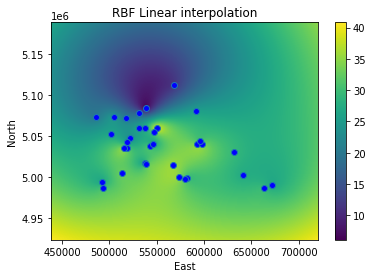

co_gdf


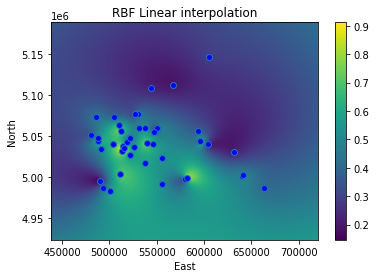

no2_gdf


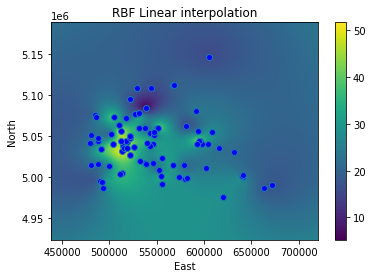

so2_gdf


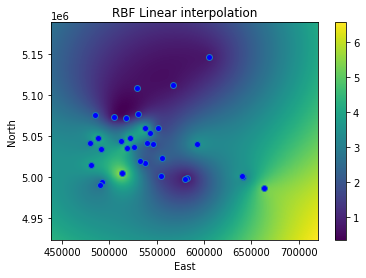

nh3_gdf


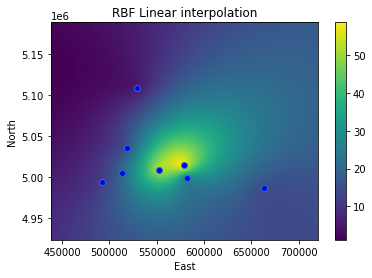

nox_gdf


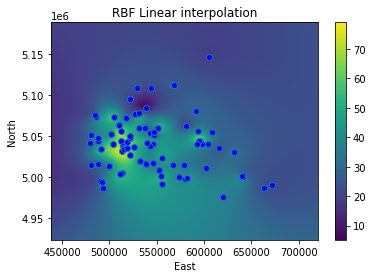

pm10_gdf


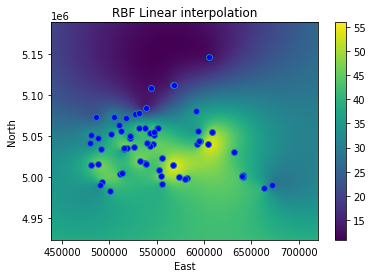

o3_gdf


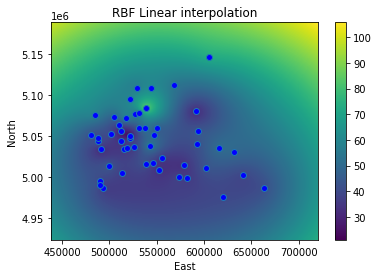

In [52]:
for key in aq_dict:
    east = aq_dict[key].geometry.x
    north = aq_dict[key].geometry.y
    value = aq_dict[key][['valore']]
    
    rbf = Rbf(east, north, value, function='linear')
    z_new = rbf(gridX.ravel(), gridY.ravel()).reshape(gridX.shape)
    print(key)
    plt.pcolor(gridX, gridY, z_new);
    plt.plot(east, north, 'o', markerfacecolor='blue');
    plt.xlabel('East'); plt.ylabel('North');
    plt.title('RBF Linear interpolation');
    plt.colorbar()
    plt.show()

    transform = Affine.translation(gridX[0][0]-rRes/2, gridY[0][0]-rRes/2)*Affine.scale(rRes,rRes)

    new_dataset = rio.open(cwd +'/temp/aq_rbf_'+key[:(len(key)-4)]+'.tif', 'w', driver='GTiff',
                            height = z_new.shape[0], width = z_new.shape[1],
                            count=1, dtype=str(z_new.dtype),
                            crs='+proj=utm +zone=32 +datum=WGS84 +units=m +no_defs',
                            transform=transform)

    new_dataset.write(z_new, 1)
    new_dataset.close()
    #Warp with GDAL since rasterio and rasterstats affine transformation don't work in the grid processing notebook
    ds = gdal.Warp(cwd +'/temp/int_'+key[:(len(key)-4)]+'.tif', cwd +'/temp/aq_rbf_'+key[:(len(key)-4)]+'.tif', dstSRS='EPSG:32632',
                   outputType=gdal.GDT_Float64, xRes=rRes, yRes=rRes)
    

temp_gdf


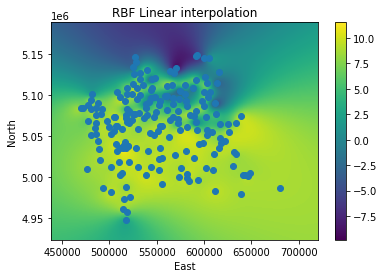

prec_gdf


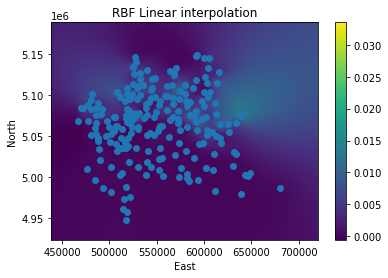

air_hum_gdf


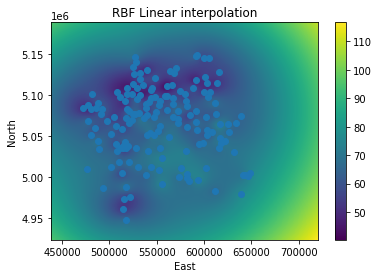

wind_speed_gdf


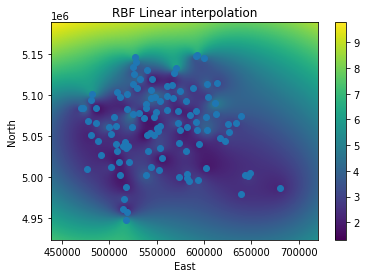

rad_glob_gdf


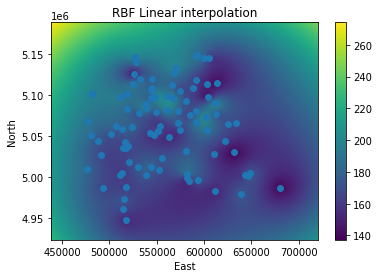

In [53]:
for key in meteo_dict:
    east = meteo_dict[key].geometry.x
    north = meteo_dict[key].geometry.y
    value = meteo_dict[key][['valore']]
    
    rbf = Rbf(east, north, value, function='linear')
    z_new = rbf(gridX.ravel(), gridY.ravel()).reshape(gridX.shape)
    print(key)
    plt.pcolor(gridX, gridY, z_new);
    plt.plot(east, north, 'o');
    plt.xlabel('East'); plt.ylabel('North');
    plt.title('RBF Linear interpolation');
    plt.colorbar()
    plt.show()

    transform = Affine.translation(gridX[0][0]-rRes/2, gridY[0][0]-rRes/2)*Affine.scale(rRes,rRes)

    new_dataset = rio.open(cwd +'/temp/meteo_rbf_'+key[:(len(key)-4)]+'.tif', 'w', driver='GTiff',
                            height = z_new.shape[0], width = z_new.shape[1],
                            count=1, dtype=str(z_new.dtype),
                            crs='+proj=utm +zone=32 +datum=WGS84 +units=m +no_defs',
                            transform=transform)

    new_dataset.write(z_new, 1)
    new_dataset.close()
    #Warp with GDAL since rasterio and rasterstats affine transformation don't work in the grid processing notebook
    ds = gdal.Warp(cwd +'/temp/int_'+key[:(len(key)-4)]+'.tif', cwd +'/temp/meteo_rbf_'+key[:(len(key)-4)]+'.tif', dstSRS='EPSG:32632',
                   outputType=gdal.GDT_Float64, xRes=rRes, yRes=rRes)

Check if Points Samplings in the interpolated raster corresponds with measured data for each stations positions. The Point Samplings (raster values obtained from interpolation) histogram is compared with the histogram of the station values:

In [90]:
len(coords)

34

34
Data name : pm25_gdf
Max value from stations: 40.5
Max value from interpolated raster: 40.44301221759601
Min value from stations: 6.0
Min value from interpolated raster: 6.098217037514942
RMSE: 0.10295708134745096


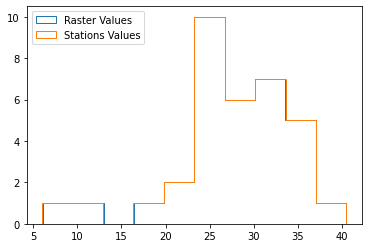

----------------------------------
45
Data name : co_gdf
Max value from stations: 0.9133802816901407
Max value from interpolated raster: 0.9121366790971788
Min value from stations: 0.14444444444444446
Min value from interpolated raster: 0.14951819813536105
RMSE: 0.0013716387925388942


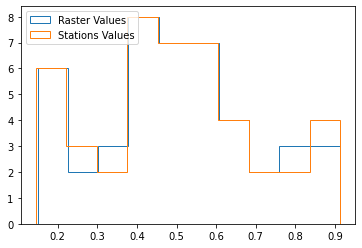

----------------------------------
85
Data name : no2_gdf
Max value from stations: 51.95384615384615
Max value from interpolated raster: 51.70999386924643
Min value from stations: 5.13125
Min value from interpolated raster: 5.268977969231173
RMSE: 0.004886277068836325


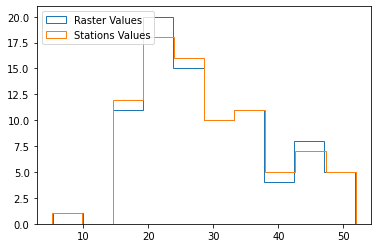

----------------------------------
33
Data name : so2_gdf
Max value from stations: 5.727659574468086
Max value from interpolated raster: 5.714511444150993
Min value from stations: 0.5631944444444444
Min value from interpolated raster: 0.5713457046642105
RMSE: 0.011079315386257683


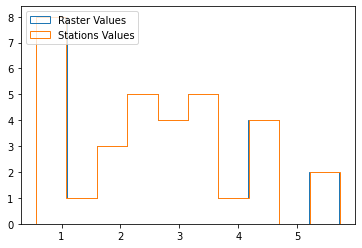

----------------------------------
8
Data name : nh3_gdf
Max value from stations: 58.699999999999996
Max value from interpolated raster: 58.66924116928109
Min value from stations: 4.883333333333334
Min value from interpolated raster: 4.884800817376146
RMSE: 0.048113394451564644


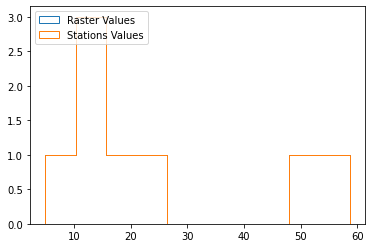

----------------------------------
84
Data name : nox_gdf
Max value from stations: 80.22189781021898
Max value from interpolated raster: 79.05947505158088
Min value from stations: 5.070833333333334
Min value from interpolated raster: 5.294020561105867
RMSE: 0.1187669609197738


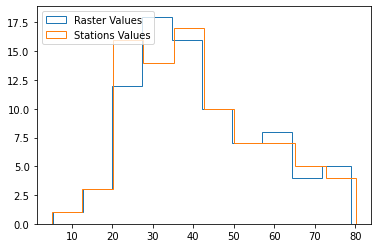

----------------------------------
65
Data name : pm10_gdf
Max value from stations: 56.0
Max value from interpolated raster: 55.91665073408507
Min value from stations: 12.0
Min value from interpolated raster: 12.012420497453377
RMSE: 0.024471836364521462


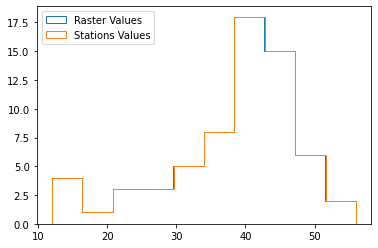

----------------------------------
50
Data name : o3_gdf
Max value from stations: 86.86041666666667
Max value from interpolated raster: 86.67296602397776
Min value from stations: 20.9
Min value from interpolated raster: 21.52823198676257
RMSE: 0.004049711059568426


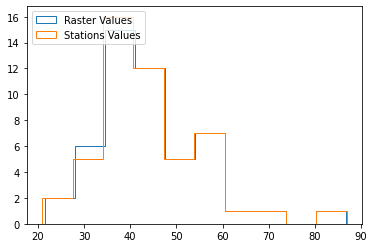

----------------------------------


In [117]:
for key in aq_dict:
    raster = rio.open(cwd +'/temp/int_'+key[:(len(key)-4)]+'.tif')
    east = aq_dict[key].geometry.x
    north = aq_dict[key].geometry.y
    value = aq_dict[key][['valore']]
    aq_dict[key].index = range(len(aq_dict[key]))
    coords = [(x,y) for x, y in zip(aq_dict[key].geometry.x,aq_dict[key].geometry.y)]
    n = len(coords)
    aq_dict[key]['Raster Value'] = [x[0] for x in raster.sample(coords)]
    rmse = ((np.sum((aq_dict[key]['Raster Value'] - aq_dict[key]['valore']))**2)/n)**(1/2)
    print(n)
    print("Data name : {name}".format(name = key))
    print("Max value from stations: {value}".format(value = aq_dict[key]['valore'].max()))
    print("Max value from interpolated raster: {value}".format(value=aq_dict[key]['Raster Value'].max()))
    print("Min value from stations: {value}".format(value = aq_dict[key]['valore'].min()))
    print("Min value from interpolated raster: {value}".format(value=aq_dict[key]['Raster Value'].min()))
    print("RMSE:", rmse)
    plt.hist(aq_dict[key]['Raster Value'], label = 'Raster Values', histtype='step')
    plt.hist(aq_dict[key]['valore'], label = 'Stations Values', histtype='step')
    plt.legend(loc="upper left")
    plt.show()
    print("----------------------------------")
    

193
Data name : temp_gdf
Max value from stations: 11.541666666666666
Max value from interpolated raster: 11.519790404960332
Min value from stations: -9.86712962962963
Min value from interpolated raster: -9.74593172036802
RMSE: 0.018174077725155766


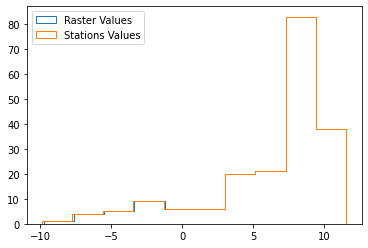

----------------------------------
210
Data name : prec_gdf
Max value from stations: 0.034722222222222224
Max value from interpolated raster: 0.033145917175014306
Min value from stations: 0.0
Min value from interpolated raster: -1.0035215284476262e-05
RMSE: 2.8372664931886612e-05


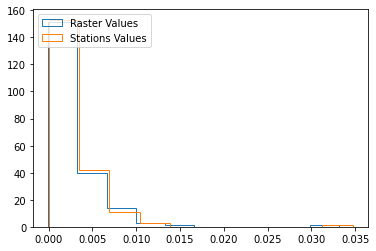

----------------------------------
160
Data name : air_hum_gdf
Max value from stations: 76.28273464658169
Max value from interpolated raster: 76.2964528084359
Min value from stations: 40.0462962962963
Min value from interpolated raster: 40.21204495760594
RMSE: 0.0532329139904124


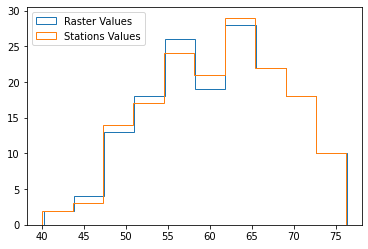

----------------------------------
115
Data name : wind_speed_gdf
Max value from stations: 6.784453781512605
Max value from interpolated raster: 6.782607118664117
Min value from stations: 1.3005787037037038
Min value from interpolated raster: 1.31697768409202
RMSE: 0.006783738355063199


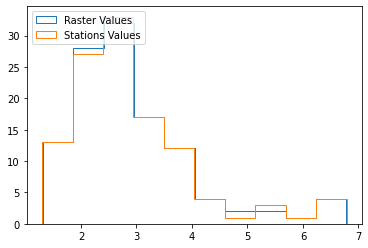

----------------------------------
92
Data name : rad_glob_gdf
Max value from stations: 208.18655851680185
Max value from interpolated raster: 208.07876469761956
Min value from stations: 137.2173611111111
Min value from interpolated raster: 137.2797465017826
RMSE: 0.1609167330408308


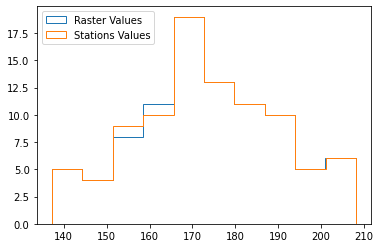

----------------------------------


In [119]:
for key in meteo_dict:
    raster = rio.open(cwd +'/temp/int_'+key[:(len(key)-4)]+'.tif')
    east = meteo_dict[key].geometry.x
    north = meteo_dict[key].geometry.y
    value = meteo_dict[key][['valore']]
    meteo_dict[key].index = range(len(meteo_dict[key]))
    coords = [(x,y) for x, y in zip(meteo_dict[key].geometry.x, meteo_dict[key].geometry.y)]
    n = len(coords)
    meteo_dict[key]['Raster Value'] = [x[0] for x in raster.sample(coords)]
    rmse = ((np.sum((meteo_dict[key]['Raster Value'] - meteo_dict[key]['valore']))**2)/n)**(1/2)
    print(n)
    print("Data name : {name}".format(name = key))
    print("Max value from stations: {value}".format(value = meteo_dict[key]['valore'].max()))
    print("Max value from interpolated raster: {value}".format(value=meteo_dict[key]['Raster Value'].max()))
    print("Min value from stations: {value}".format(value = meteo_dict[key]['valore'].min()))
    print("Min value from interpolated raster: {value}".format(value=meteo_dict[key]['Raster Value'].min()))
    print("RMSE:", rmse)
    plt.hist(meteo_dict[key]['Raster Value'], label = 'Raster Values', histtype='step')
    plt.hist(meteo_dict[key]['valore'], label = 'Stations Values', histtype='step')
    plt.legend(loc="upper left")
    plt.show()
    print("----------------------------------")
        

# ESA LPS Air Quality Platform data request notebook

This notebook is used to download data from both meteorological and air quality ground sensor of LPS Air Quality Platform data.

The data are retrieved using the API service.
The sensors available are: 
- PM2.5
- PM10
- NO2
- CO2
- NH3
- CO
- Temperature
- Humidity

The API request downloads the data in the given time range. A Z-Score test is performed to remove outliers and the mean value for each sensor is calculated.
Mean values for each sensor are saved in geopackage format.

### Reference website: 
- ESA LPS Air Quality Platform: https://aqp.eo.esa.int/aqstation/
- ESA LPS Air Quality Platform sensor map: https://aqp.eo.esa.int/map/

In [56]:
device_list = [1, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 36, 58]  #list of devices considered to make the request. Check on map on the website

In [57]:
aq_data = []

In [58]:
for i in range(len(device_list)):
    url = 'https://api.aqp.eo.esa.int/api/device/'+str(device_list[i])+'/csv?start_date='+start_date+'&end_date='+end_date
    urlData = requests.get(url).content
    rawData = pd.read_csv(io.StringIO(urlData.decode('utf-8')))
    aq_data.append(rawData)

df_data = pd.concat((pd.DataFrame(data) for data in aq_data), ignore_index=True)

In [59]:
list_active = list(df_data.device_id.unique())
list_active

[12, 13, 16, 36]

In [60]:
aq_data = []
del df_data

In [61]:
for i in range(len(list_active)):
    url = 'https://api.aqp.eo.esa.int/api/device/'+str(list_active[i])+'/csv?start_date='+start_date+'&end_date='+end_date
    urlData = requests.get(url).content
    rawData = pd.read_csv(io.StringIO(urlData.decode('utf-8')))
    aq_data.append(rawData)

df_data = pd.concat((pd.DataFrame(data) for data in aq_data), ignore_index=True)

In [62]:
sel_columns = ['device_id', 'acquisition_date','latitude', 
           'longitude', 'pm25', 'pm10', 'humidity', 'temperature',
          'no2', 'co2', 'nh3', 'co']

In [63]:
df = df_data[sel_columns]

In [64]:
df

,device_id,acquisition_date,latitude,longitude,pm25,pm10,humidity,temperature,no2,co2,nh3,co
0,12,2021-03-10 00:00:52,45.803494,9.094750,251.3,1999.9,69.1,10.9,0.25,583.29,0.61,3.97
1,12,2021-03-10 00:01:59,45.802880,9.094642,213.4,1999.9,68.7,10.9,0.25,583.29,0.61,3.97
2,12,2021-03-10 00:03:10,45.802880,9.094642,92.7,1124.6,68.2,10.9,0.25,583.29,0.61,3.97
3,12,2021-03-10 00:04:18,45.802880,9.094642,138.0,1559.7,68.1,11.0,0.25,601.91,0.61,3.97
4,12,2021-03-10 00:05:25,45.802908,9.094968,207.9,1999.9,68.1,11.0,0.25,601.91,0.61,3.97
...,...,...,...,...,...,...,...,...,...,...,...,...
35071,36,2021-03-16 23:54:46,45.534771,10.231425,0.1,0.1,14.7,19.2,0.17,1027.10,0.54,3.62
35072,36,2021-03-16 23:55:51,45.534771,10.231425,0.1,0.1,14.7,19.2,0.17,995.32,0.54,3.62
35073,36,2021-03-16 23:56:55,45.534771,10.231425,0.1,0.1,14.7,19.2,0.17,995.32,0.54,3.62
35074,36,2021-03-16 23:58:00,45.534771,10.231425,0.1,0.2,14.7,19.2,0.17,1027.10,0.54,3.62


In [65]:
df['acquisition_date'] = pd.to_datetime(df['acquisition_date'], format='%Y-%m-%d %H:%M:%S')

In [66]:
pm25 = df[['device_id','acquisition_date', 'latitude', 'longitude', 'pm25']]
pm10 = df[['device_id','acquisition_date', 'latitude', 'longitude', 'pm10']]
humidity = df[['device_id','acquisition_date', 'latitude', 'longitude', 'humidity']]
temperature = df[['device_id','acquisition_date', 'latitude', 'longitude', 'temperature']]
no2 = df[['device_id','acquisition_date', 'latitude', 'longitude', 'no2']]
co2 = df[['device_id','acquisition_date', 'latitude', 'longitude', 'co2']]
nh3 = df[['device_id','acquisition_date', 'latitude', 'longitude', 'nh3']]
co = df[['device_id','acquisition_date', 'latitude', 'longitude', 'co']]

In [67]:
pm25 = pm25.rename(columns={'pm25': 'value'})
pm10 = pm10.rename(columns={'pm10': 'value'})
humidity = humidity.rename(columns={'humidity': 'value'})
temperature = temperature.rename(columns={'temperature': 'value'})
no2 = no2.rename(columns={'no2': 'value'})
co2 = co2.rename(columns={'co2': 'value'})
nh3 = nh3.rename(columns={'nh3': 'value'})
co = co.rename(columns={'co': 'value'})

In [68]:
pm25['zscore'] = np.abs(stats.zscore(pm25['value'], nan_policy='omit'))
pm25 = pm25[pm25.zscore < threshold]
pm25 = pm25.groupby(['device_id'],as_index=False).mean()

In [69]:
pm10['zscore'] = np.abs(stats.zscore(pm10['value'], nan_policy='omit'))
pm10 = pm10[pm10.zscore < threshold]
pm10 = pm10.groupby(['device_id'],as_index=False).mean()

In [70]:
humidity['zscore'] = np.abs(stats.zscore(humidity['value'], nan_policy='omit'))
humidity = humidity[humidity.zscore < threshold]
humidity = humidity.groupby(['device_id'],as_index=False).mean()

In [71]:
temperature['zscore'] = np.abs(stats.zscore(temperature['value'], nan_policy='omit'))
temperature = temperature[temperature.zscore < threshold]
temperature = temperature.groupby(['device_id'],as_index=False).mean()

In [72]:
no2['zscore'] = np.abs(stats.zscore(no2['value'], nan_policy='omit'))
no2 = no2[no2.zscore < threshold]
no2 = no2.groupby(['device_id'],as_index=False).mean()

In [73]:
co2['zscore'] = np.abs(stats.zscore(co2['value'], nan_policy='omit'))
co2 = co2[co2.zscore < threshold]
co2 = co2.groupby(['device_id'],as_index=False).mean()

In [74]:
nh3['zscore'] = np.abs(stats.zscore(nh3['value'], nan_policy='omit'))
nh3 = nh3[nh3.zscore < threshold]
nh3 = nh3.groupby(['device_id'],as_index=False).mean()

In [75]:
co['zscore'] = np.abs(stats.zscore(co['value'], nan_policy='omit'))
co = co[co.zscore < threshold]
co = co.groupby(['device_id'],as_index=False).mean()

Create Geodataframe and save in geopackage:

In [76]:
pm25_gdf = gpd.GeoDataFrame(pm25, geometry=gpd.points_from_xy(pm25.longitude, pm25.latitude)).set_crs('epsg:4326')
pm10_gdf = gpd.GeoDataFrame(pm10, geometry=gpd.points_from_xy(pm10.longitude, pm10.latitude)).set_crs('epsg:4326')
hum_gdf = gpd.GeoDataFrame(humidity, geometry=gpd.points_from_xy(humidity.longitude, humidity.latitude)).set_crs('epsg:4326')
temp_gdf = gpd.GeoDataFrame(temperature, geometry=gpd.points_from_xy(temperature.longitude, temperature.latitude)).set_crs('epsg:4326')
no2_gdf = gpd.GeoDataFrame(no2, geometry=gpd.points_from_xy(no2.longitude, no2.latitude)).set_crs('epsg:4326')
co2_gdf = gpd.GeoDataFrame(co2, geometry=gpd.points_from_xy(co2.longitude, co2.latitude)).set_crs('epsg:4326')
nh3_gdf = gpd.GeoDataFrame(nh3, geometry=gpd.points_from_xy(nh3.longitude, nh3.latitude)).set_crs('epsg:4326')
co_gdf = gpd.GeoDataFrame(co, geometry=gpd.points_from_xy(co.longitude, co.latitude)).set_crs('epsg:4326')

In [77]:
pm25_gdf.to_file(cwd+"/temp/pm25_lcs.gpkg", driver="GPKG")
pm10_gdf.to_file(cwd+"/temp/pm10_lcs.gpkg", driver="GPKG")
hum_gdf.to_file(cwd+"/temp/hum_lcs.gpkg", driver="GPKG")
temp_gdf.to_file(cwd+"/temp/temp_lcs.gpkg", driver="GPKG")
no2_gdf.to_file(cwd+"/temp/no2_lcs.gpkg", driver="GPKG")
co2_gdf.to_file(cwd+"/temp/co2_lcs.gpkg", driver="GPKG")
nh3_gdf.to_file(cwd+"/temp/nh3_lcs.gpkg", driver="GPKG")
co_gdf.to_file(cwd+"/temp/co_lcs.gpkg", driver="GPKG")

In [78]:
pm10_gdf

,device_id,latitude,longitude,value,zscore,geometry
0,12,45.803050,9.095053,547.543351,1.196089,POINT (9.09505 45.80305)
1,13,45.477743,9.141367,19.260051,0.261216,POINT (9.14137 45.47774)
2,16,45.477748,9.227293,0.304784,0.301579,POINT (9.22729 45.47775)
3,36,45.534771,10.231425,2.845755,0.296168,POINT (10.23142 45.53477)


In [79]:
bnd = gpd.read_file('C:/Users/Administrator/OneDrive - Politecnico di Milano/WP2/D-DUST/boundaries/lombardy_region2020.gpkg').to_crs('epsg:4326')

<AxesSubplot:>

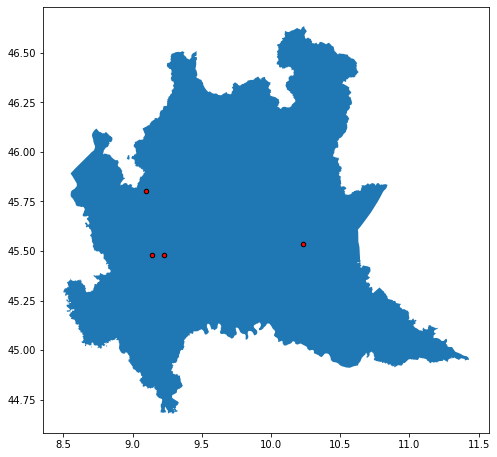

In [80]:
fig, ax = plt.subplots(figsize=(8, 8))
bnd.plot(ax = ax);
hum_gdf.plot(ax=ax,marker='o', color='red', markersize=20, edgecolors='black')